# Indexing

This notebook helps understanding Transflow's core mechanics.

In [10]:
import matplotlib.pyplot as plt
import numpy

In [11]:
def plot_flow(array: numpy.ndarray):
    from matplotlib.axes import Axes
    vmin, vmax = numpy.min(array), numpy.max(array)
    fig, axes_array = plt.subplots(1, 2)
    axes: list[Axes] = axes_array.tolist()
    axes[0].imshow(array[:,:,0], vmin=vmin, vmax=vmax, extent=(0, array.shape[1], 0, array.shape[0]), origin="upper")
    axes[0].set_title("X")
    im = axes[1].imshow(array[:,:,1], vmin=vmin, vmax=vmax, extent=(0, array.shape[1], 0, array.shape[0]), origin="upper")
    axes[1].set_title("Y")
    for ax in axes:
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        ax.set_xticks(range(0, array.shape[1] + 1))
        ax.set_yticks(range(0, array.shape[0] + 1), map(str, range(array.shape[0], -1, -1)))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            axes[0].text(j+.5, i+.5, array[array.shape[0] - 1 - i,j,0], ha="center", va="center")
            axes[1].text(j+.5, i+.5, array[array.shape[0] - 1 - i,j,1], ha="center", va="center")
    plt.tight_layout()

def plot_mask(array: numpy.ndarray, title: str | None = None):
    plt.figure(figsize=(5, 3))
    plt.imshow(array, origin="upper", vmin=0, vmax=1, cmap="grey", extent=(0, array.shape[1], 0, array.shape[0]))
    plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.xticks(range(0, array.shape[1] + 1))
    plt.yticks(range(0, array.shape[0] + 1), list(map(str, range(array.shape[0], -1, -1))))
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    
def plot_bitmap(array: numpy.ndarray, title: str | None = None):
    plt.figure(figsize=(5, 3))
    plt.imshow(array, origin="upper", extent=(0, array.shape[1], 0, array.shape[0]))
    plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.xticks(range(0, array.shape[1] + 1))
    plt.yticks(range(0, array.shape[0] + 1), list(map(str, range(array.shape[0], -1, -1))))
    if title is not None:
        plt.title(title)
    plt.tight_layout()


Applying the flow to a bitmap.

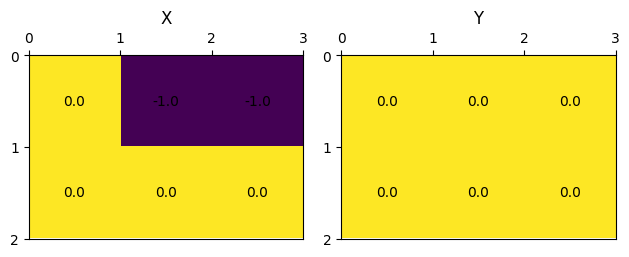

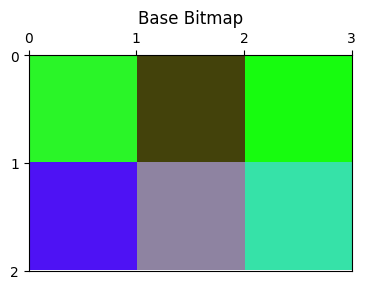

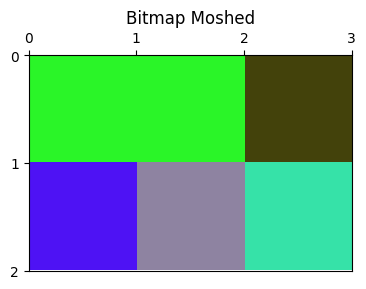

In [12]:
flow = numpy.zeros((2, 3, 2))
flow[0,1] = (-1, 0)
flow[0,2] = (-1, 0)
plot_flow(flow)

bitmap = numpy.random.randint(0, 255, size=(2, 3, 3), dtype=numpy.uint8)
plot_bitmap(bitmap, "Base Bitmap")

flow_int = numpy.round(flow).astype(numpy.int32)
flow_flat = numpy.ravel(flow_int[:,:,1] * 3 + flow_int[:,:,0])
remap = (numpy.arange(2 * 3) + flow_flat) * 3
base = numpy.arange(2 * 3) * 3
bitmap_moshed = numpy.zeros((2, 3, 3), dtype=numpy.uint8)
for i in range(3):
    numpy.put(bitmap_moshed, base+i, bitmap.flat[remap+i], mode="clip")
plot_bitmap(bitmap_moshed, "Bitmap Moshed")


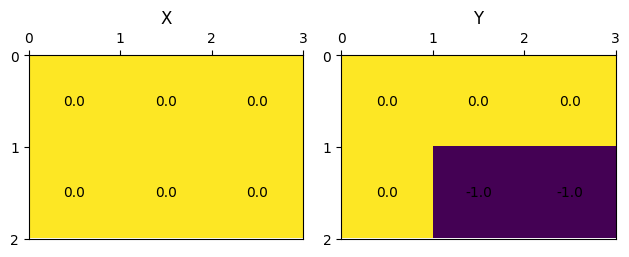

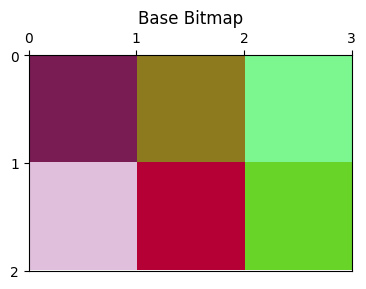

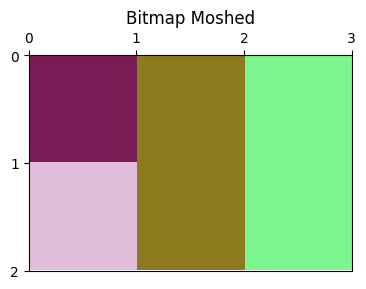

In [13]:
flow = numpy.zeros((2, 3, 2))
flow[1,1] = (0, -1)
flow[1,2] = (0, -1)
plot_flow(flow)

bitmap = numpy.random.randint(0, 255, size=(2, 3, 3), dtype=numpy.uint8)
plot_bitmap(bitmap, "Base Bitmap")

flow_int = numpy.round(flow).astype(numpy.int32)
flow_flat = numpy.ravel(flow_int[:,:,1] * 3 + flow_int[:,:,0])
remap = (numpy.arange(2 * 3) + flow_flat) * 3
base = numpy.arange(2 * 3) * 3
bitmap_moshed = numpy.zeros((2, 3, 3), dtype=numpy.uint8)
for i in range(3):
    numpy.put(bitmap_moshed, base+i, bitmap.flat[remap+i], mode="clip")
plot_bitmap(bitmap_moshed, "Bitmap Moshed")


Moshing a mask designed to filter the starting position of moving pixels and express it as a matrix of end positions.

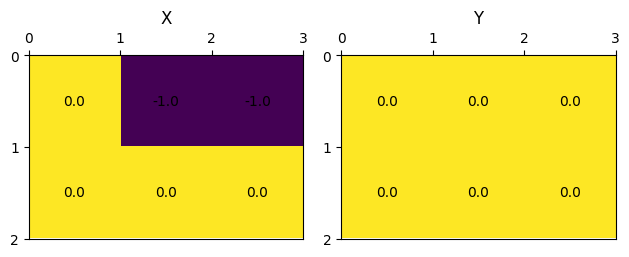

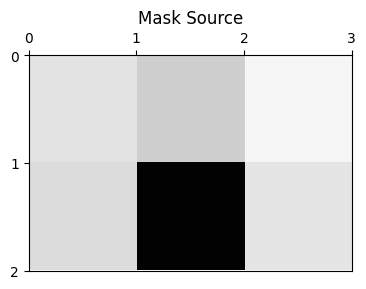

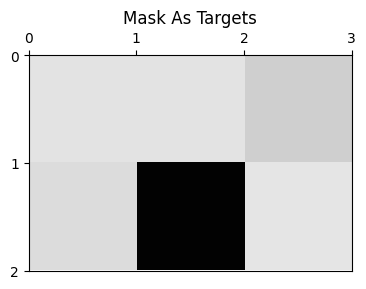

In [14]:
flow = numpy.zeros((2, 3, 2))
flow[0,1] = (-1, 0)
flow[0,2] = (-1, 0)
plot_flow(flow)

# mask = numpy.ones((2, 3), dtype=int)
# mask[:,0] = 0
mask = numpy.random.random((2, 3))
plot_mask(mask, "Mask Source")

# Compositor._update_move
flow_int = numpy.round(flow).astype(numpy.int32)
flow_flat = numpy.ravel(flow_int[:,:,1] * 3 + flow_int[:,:,0])
remap = numpy.arange(2 * 3) + flow_flat
mask_rev = mask.flat[remap].reshape((2, 3))
plot_mask(mask_rev, "Mask As Targets")

# Flipping Flow from an [X, Y] array to [I, J] array

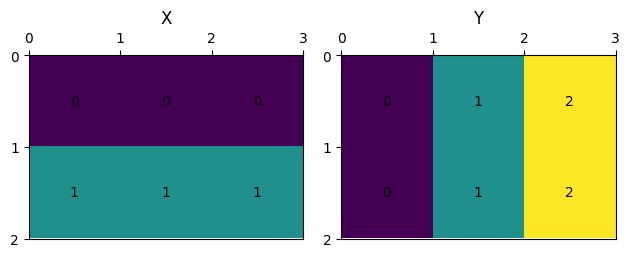

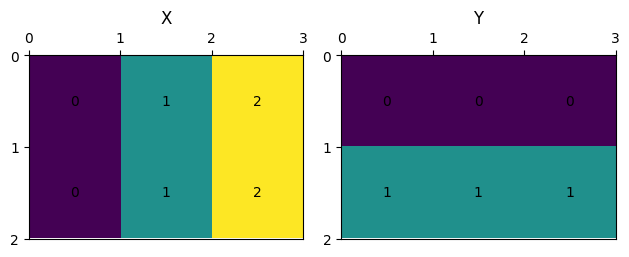

In [15]:
a = numpy.indices((2, 3), dtype=numpy.int32).transpose(1, 2, 0)
b = numpy.flip(a, axis=2)
plot_flow(a)
plot_flow(b)

# MappingLayer._update_move

Naive version

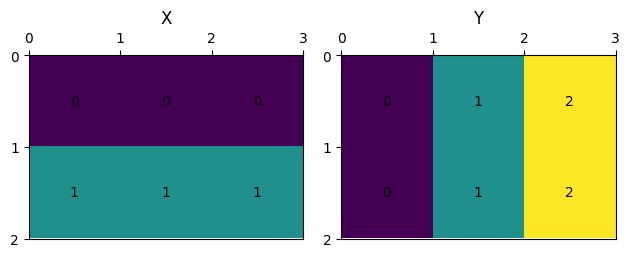

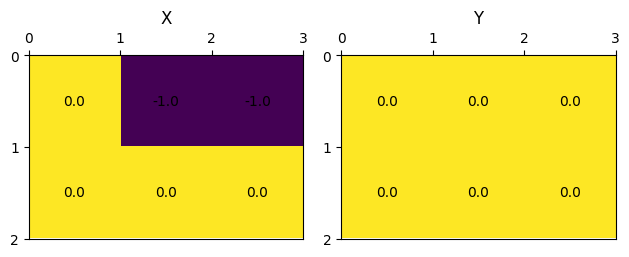

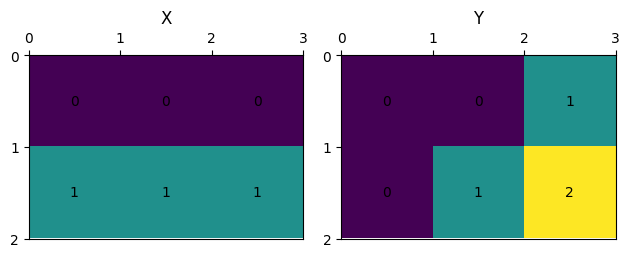

In [16]:
base = numpy.indices((2, 3), dtype=numpy.int32).transpose(1, 2, 0)
mapping = base.copy()
plot_flow(mapping)
flow = numpy.zeros((2, 3, 2))
flow[0,1] = (-1, 0)
flow[0,2] = (-1, 0)
plot_flow(flow)
remap = numpy.clip(numpy.round(base + numpy.flip(flow, axis=2)), [0, 0], [2 - 1, 3 - 1]).astype(numpy.int32)
aux = mapping.copy()
mapping = aux[remap[:,:,0], remap[:,:,1]]
plot_flow(mapping)

Advanced version

Flow flat [ 0 -1 -1  0  0  0]
Mask all flat [False False  True  True  True  True]
Target [2]
Source [1]


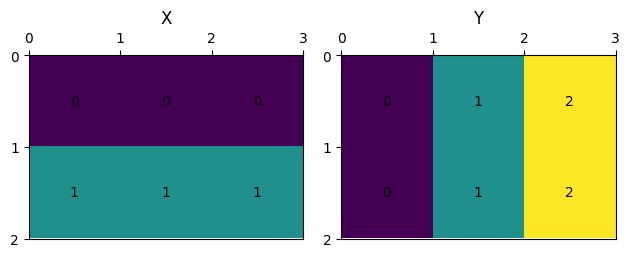

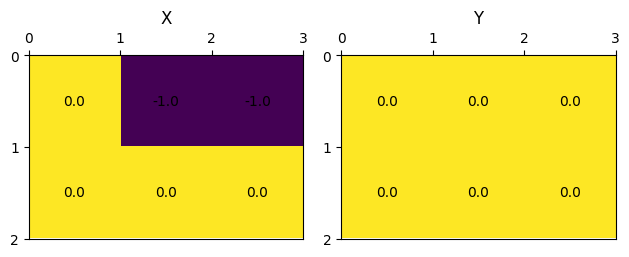

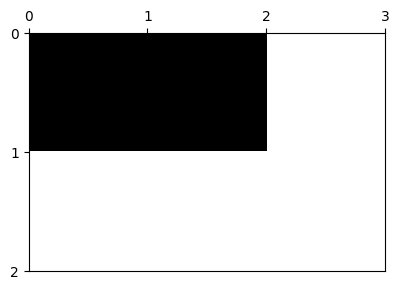

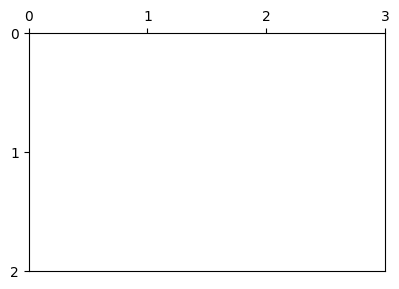

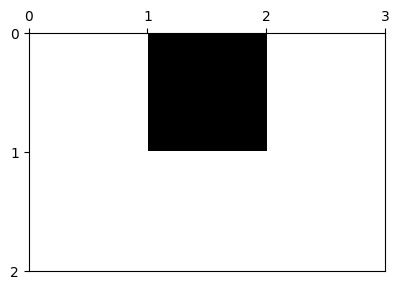

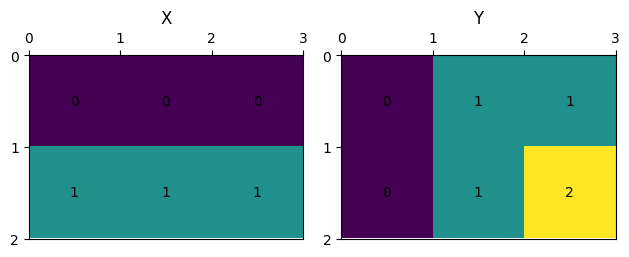

In [17]:
def putn(target_array: numpy.ndarray, source_array: numpy.ndarray, target_inds: numpy.ndarray, source_inds: numpy.ndarray, scale: int):
    target_inds_scaled = target_inds * scale
    source_inds_scaled = source_inds * scale
    for i in range(scale):
        target_array.flat[target_inds_scaled + i] = source_array.flat[source_inds_scaled + i]


def putn_1d(target_array: numpy.ndarray, value: int | float, target_inds: numpy.ndarray, scale: int, axis: int):
    target_inds_scaled = target_inds * scale
    target_array.flat[target_inds_scaled + axis] = value


height, width = 2, 3
base = numpy.indices((height, width), dtype=numpy.int32).transpose(1, 2, 0)
mapping = base.copy()
plot_flow(mapping)

transparent_pixels_can_move = False
pixels_can_move_to_empty_spot = True
pixels_can_move_to_filled_spot = True
moving_pixels_leave_empty_spot = True

mask_src = numpy.ones((height, width), dtype=numpy.bool)
mask_src[0,0] = 0 # TODO: test
mask_dst = numpy.ones((height, width), dtype=numpy.bool)
mask_alpha = numpy.ones((height, width), dtype=numpy.bool)

flow = numpy.zeros((2, 3, 2))
flow[0,1] = (-1, 0)
flow[0,2] = (-1, 0)
plot_flow(flow)

flow_int = numpy.round(flow).astype(numpy.int32)
flow_flat = numpy.ravel(flow_int[:,:,1] * width + flow_int[:,:,0])

print("Flow flat", flow_flat)

shift = numpy.arange(height * width) + flow_flat
if not transparent_pixels_can_move:
    mask_src[numpy.where(mask_alpha == 0)] = 0
mask_src = mask_src.flat[shift].reshape((height, width))

if not pixels_can_move_to_empty_spot:
    mask_dst[numpy.where(mask_alpha == 0)] = 0
if not pixels_can_move_to_filled_spot:
    mask_dst[numpy.nonzero(mask_alpha)] = 0

mask_all_flat = numpy.multiply(mask_src.flat, mask_dst.flat)
where_target = numpy.nonzero(numpy.multiply(flow_flat, mask_all_flat))[0]
where_source = where_target + flow_flat[where_target]

print("Mask all flat", mask_all_flat)
print("Target", where_target)
print("Source", where_source)

if moving_pixels_leave_empty_spot:
    putn_1d(mask_alpha, 0, where_source, 1, 0)
    putn_1d(mask_alpha, 1, where_target, 1, 0)
putn(mapping, mapping.copy(), where_target, where_source, 2)

plot_mask(mask_src)
plot_mask(mask_dst)
plot_mask(mask_alpha)
plot_flow(mapping)


# Add alpha channel to RGB

(2, 3, 4) int32


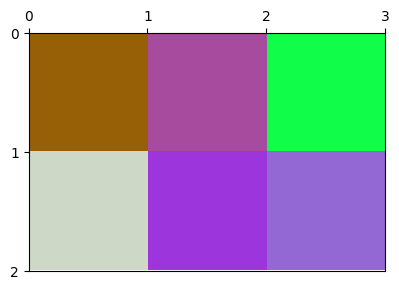

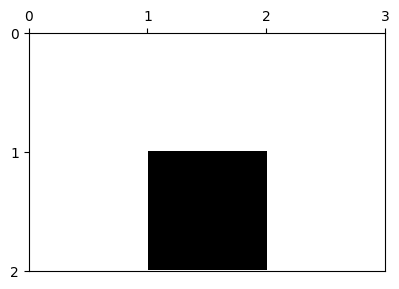

In [18]:
rgb = numpy.random.randint(0, 255, (2, 3, 3), dtype=numpy.uint8)
plot_bitmap(rgb)
alpha = numpy.ones((2, 3), dtype=numpy.bool)
alpha[1,1] = 0
plot_mask(alpha)
rgba = numpy.append(rgb, 255 * alpha.reshape(2, 3, 1), axis=2).astype(numpy.int32)
print(rgba.shape, rgba.dtype)